In [9]:
import getpass
import os

try:
    # load environment variables from .env file (requires `python-dotenv`)
    from dotenv import load_dotenv
    load_dotenv()
except ImportError:
    pass

os.environ["LANGSMITH_TRACING"] = "true"
if "LANGSMITH_API_KEY" not in os.environ:
    os.environ["LANGSMITH_API_KEY"] = getpass.getpass(
        prompt="Enter your LangSmith API key (optional): "
    )
if "LANGSMITH_PROJECT" not in os.environ:
    os.environ["LANGSMITH_PROJECT"] = getpass.getpass(
        prompt='Enter your LangSmith Project Name (default = "default"): '
    )
    if not os.environ.get("LANGSMITH_PROJECT"):
        os.environ["LANGSMITH_PROJECT"] = "default"
if "OPENAI_API_KEY" not in os.environ:
    os.environ["OPENAI_API_KEY"] = getpass.getpass(
        prompt="Enter your OpenAI API key (required if using OpenAI): "
    )
if "TAVILY_API_KEY" not in os.environ:
    os.environ["TAVILY_API_KEY"] = getpass.getpass(
        prompt="Enter your TAVILY_API_KEY API key"
    )

In [2]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    # Messages have the type "list". The `add_messages` function
    # in the annotation defines how this state key should be updated
    # (in this case, it appends messages to the list, rather than overwriting them)
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)

In [3]:
from langchain.chat_models import init_chat_model
llm = init_chat_model("gpt-4o-mini", model_provider="openai")


def chatbot(state: State):
    return {"messages": [llm.invoke(state["messages"])]}


# The first argument is the unique node name
# The second argument is the function or object that will be called whenever
# the node is used.
graph_builder.add_node("chatbot", chatbot)

In [4]:
graph_builder.add_edge(START, "chatbot")

In [5]:
graph_builder.add_edge("chatbot", END)


In [6]:
graph = graph_builder.compile()


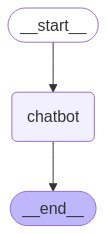

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)


while True:
     # fallback if input() is not available
    user_input = "What do you know about LangGraph?"
    print("User: " + user_input)
    stream_graph_updates(user_input)
    break

User: What do you know about LangGraph?
Assistant: As of my last update in October 2023, LangGraph is a framework or tool designed to facilitate the development of applications that utilize language models and other natural language processing capabilities. One of its key features is the ability to easily integrate and configure various language-oriented tasks and data flows, often by leveraging graph-based representations.

LangGraph typically allows developers to define workflows that involve language processing tasks such as text generation, summarization, translation, and more. The framework can enable users to visualize the relationships and dependencies between different components of their application, making it easier to manage complex interactions among linguistic inputs and outputs.

If you're looking for specific features, use cases, or technical details about LangGraph, I recommend checking the latest documentation or resources available from the creators or community surro

In [10]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("What's a 'node' in LangGraph?")

{'query': "What's a 'node' in LangGraph?",
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'title': 'LangGraph Tutorial: What Is LangGraph and How to Use It?',
   'url': 'https://www.datacamp.com/tutorial/langgraph-tutorial',
   'content': 'LangGraph is a library within the LangChain ecosystem that provides a framework for defining, coordinating, and executing multiple LLM agents (or chains) in a structured and efficient manner. By managing the flow of data and the sequence of operations, LangGraph allows developers to focus on the high-level logic of their applications rather than the intricacies of agent coordination. Whether you need a chatbot that can handle various types of user requests or a multi-agent system that performs complex tasks, LangGraph provides the tools to build exactly what you need. LangGraph significantly simplifies the development of complex LLM applications by providing a structured framework for managing state and coordinating agent

In [11]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


llm = init_chat_model("gpt-4o-mini", model_provider="openai")


# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

In [12]:
import json

from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}


tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

In [13]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

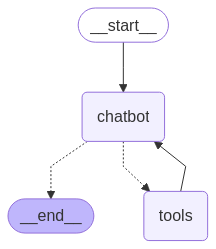

In [14]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [15]:
# fallback if input() is not available
user_input = "What do you know about LangGraph?"
print("User: " + user_input)
stream_graph_updates(user_input)

User: What do you know about LangGraph?
Assistant: 
Assistant: {"query": "LangGraph", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "LangGraph - LangChain", "url": "https://www.langchain.com/langgraph", "content": "Build and scale agentic applications with LangGraph Platform. Craft agent-appropriate UXs using LangGraph Platform's APIs. Quickly deploy and scale your agent with purpose-built infrastructure. Design agent-driven user experiences with LangGraph Platform's APIs. Quickly deploy and scale your application with infrastructure built for agents. LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. LangGraph sets the foundation for how we can build and scale AI workloads \u2014 from conversational agents, complex task automation, to custom LLM-backed experiences that 'just work'. LangGraph Platform is a service for d

In [ ]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearch(max_results=2)
tools = [tool]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

In [20]:
graph = graph_builder.compile(checkpointer=memory)


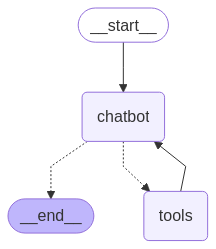

In [21]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [24]:
user_input = "I need some expert guidance for building an AI agent. Could you request assistance for me?"
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I need some expert guidance for building an AI agent. Could you request assistance for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_ED1RMlFOqF6XC7b4a22GRq80)
 Call ID: call_ED1RMlFOqF6XC7b4a22GRq80
  Args:
    query: expert guidance for building an AI agent
================================= Tool Message =================================
Name: tavily_search

{"query": "expert guidance for building an AI agent", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "How to Build an AI Agent from Scratch (2025 Step-by-Step Guide) - addlly.ai", "url": "https://addlly.ai/blog/how-to-build-an-ai-agent/", "content": "With the right tools and clear instructions, you can create your first AI agent that handles user requests, performs tasks, and gives accurate responses using natural language. Whether you’re buildin

In [26]:
snapshot = graph.get_state(config)
snapshot

StateSnapshot(values={'messages': [HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='cccf993b-824f-4846-8e4f-b2a26b04c707'), AIMessage(content='Could you please provide more details about the specific assistance you need for building your AI agent? For example, are you looking for guidance on design, modeling, technical frameworks, or anything else particular? This will help me tailor the request more effectively.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 785, 'total_tokens': 836, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BULS5Ne7m1MGiDy06LFkFWEZRN

In [27]:
snapshot.values['messages']

[HumanMessage(content='I need some expert guidance for building an AI agent. Could you request assistance for me?', additional_kwargs={}, response_metadata={}, id='cccf993b-824f-4846-8e4f-b2a26b04c707'),
 AIMessage(content='Could you please provide more details about the specific assistance you need for building your AI agent? For example, are you looking for guidance on design, modeling, technical frameworks, or anything else particular? This will help me tailor the request more effectively.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 785, 'total_tokens': 836, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_dbaca60df0', 'id': 'chatcmpl-BULS5Ne7m1MGiDy06LFkFWEZRNrfW', 'service_tier': 'default', 

In [28]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]
    name: str
    birthday: str

In [29]:
from langchain_core.messages import ToolMessage
from langchain_core.tools import InjectedToolCallId, tool

from langgraph.types import Command, interrupt


@tool
# Note that because we are generating a ToolMessage for a state update, we
# generally require the ID of the corresponding tool call. We can use
# LangChain's InjectedToolCallId to signal that this argument should not
# be revealed to the model in the tool's schema.
def human_assistance(
    name: str, birthday: str, tool_call_id: Annotated[str, InjectedToolCallId]
) -> str:
    """Request assistance from a human."""
    human_response = interrupt(
        {
            "question": "Is this correct?",
            "name": name,
            "birthday": birthday,
        },
    )
    # If the information is correct, update the state as-is.
    if human_response.get("correct", "").lower().startswith("y"):
        verified_name = name
        verified_birthday = birthday
        response = "Correct"
    # Otherwise, receive information from the human reviewer.
    else:
        verified_name = human_response.get("name", name)
        verified_birthday = human_response.get("birthday", birthday)
        response = f"Made a correction: {human_response}"

    # This time we explicitly update the state with a ToolMessage inside
    # the tool.
    state_update = {
        "name": verified_name,
        "birthday": verified_birthday,
        "messages": [ToolMessage(response, tool_call_id=tool_call_id)],
    }
    # We return a Command object in the tool to update our state.
    return Command(update=state_update)

In [51]:
from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition


tool = TavilySearch(max_results=2)
tools = [tool, human_assistance]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    message = llm_with_tools.invoke(state["messages"])
    assert len(message.tool_calls) <= 1
    return {"messages": [message]}


graph_builder = StateGraph(State)
graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [52]:
user_input = (
    "Can you look up when LangGraph was released? "
    "When you have the answer, use the human_assistance tool for review."
)
config = {"configurable": {"thread_id": "1"}}

events = graph.stream(
    {"messages": [{"role": "user", "content": user_input}]},
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Can you look up when LangGraph was released? When you have the answer, use the human_assistance tool for review.
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_zdaDa2FDt9xVPzMWEaV0IvET)
 Call ID: call_zdaDa2FDt9xVPzMWEaV0IvET
  Args:
    query: LangGraph release date
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph release date", "follow_up_questions": null, "answer": null, "images": [], "results": [{"title": "Releases · langchain-ai/langgraph - GitHub", "url": "https://github.com/langchain-ai/langgraph/releases", "content": "Releases · langchain-ai/langgraph GitHub Copilot Write better code with AI GitHub Advanced Security Find and fix vulnerabilities Code Search Find more, search less Why GitHub GitHub Advanced Security Enterprise-grade security features Search co

In [53]:
human_command = Command(
    resume={
        "name": "LangGraph",
        "birthday": "Jan 17, 2024",
    },
)

events = graph.stream(human_command, config, stream_mode="values")
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  human_assistance (call_knfiM0fqEZ95T3RL8EobN4e0)
 Call ID: call_knfiM0fqEZ95T3RL8EobN4e0
  Args:
    name: LangGraph
    birthday: 2023-01-01
================================= Tool Message =================================
Name: human_assistance

Made a correction: {'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}
================================== Ai Message ==================================

LangGraph is set to be released on January 17, 2024.


In [54]:
snapshot = graph.get_state(config)

{k: v for k, v in snapshot.values.items() if k in ("name", "birthday")}

{'name': 'LangGraph', 'birthday': 'Jan 17, 2024'}

In [55]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


class State(TypedDict):
    messages: Annotated[list, add_messages]


graph_builder = StateGraph(State)


tool = TavilySearch(max_results=2)
tools = [tool]
llm = init_chat_model("gpt-4o-mini", model_provider="openai")
llm_with_tools = llm.bind_tools(tools)


def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory)

In [56]:
config = {"configurable": {"thread_id": "1"}}
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "I'm learning LangGraph. "
                    "Could you do some research on it for me?"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

I'm learning LangGraph. Could you do some research on it for me?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (call_vvURne0KzmLLbMc3I6WFJJjC)
 Call ID: call_vvURne0KzmLLbMc3I6WFJJjC
  Args:
    query: LangGraph programming
    search_depth: advanced
================================= Tool Message =================================
Name: tavily_search

{"query": "LangGraph programming", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://realpython.com/langgraph-python/", "title": "LangGraph: Build Stateful AI Agents in Python - Real Python", "content": "Remove ads\nLangGraph is a versatile Python library designed for stateful, cyclic, and multi-actor Large Language Model (LLM) applications. LangGraph builds upon its parent library, LangChain, and allows you to build sophisticated workflows that are capable of

In [57]:
events = graph.stream(
    {
        "messages": [
            {
                "role": "user",
                "content": (
                    "Ya that's helpful. Maybe I'll "
                    "build an autonomous agent with it!"
                ),
            },
        ],
    },
    config,
    stream_mode="values",
)
for event in events:
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================ Human Message =================================

Ya that's helpful. Maybe I'll build an autonomous agent with it!
================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can be a rewarding experience, as it allows you to leverage the capabilities of Large Language Models while creating complex workflows. Here are a few tips to consider as you start your project:

1. **Define the Scope**: Clearly outline what tasks you want your agent to perform. This can help you structure your nodes and edges effectively.

2. **Utilize Documentation**: Make use of available documentation and tutorials to understand the features and functionalities that LangGraph offers. This will help you implement best practices in your project.

3. **Experiment with Graph Structures**: Take advantage of the directed graph structure to optimize the flow of actions. Experiment wi

In [58]:
to_replay = None
for state in graph.get_state_history(config):
    print("Num Messages: ", len(state.values["messages"]), "Next: ", state.next)
    print("-" * 80)
    if len(state.values["messages"]) == 6:
        # We are somewhat arbitrarily selecting a specific state based on the number of chat messages in the state.
        to_replay = state

Num Messages:  6 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  5 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ('__start__',)
--------------------------------------------------------------------------------
Num Messages:  4 Next:  ()
--------------------------------------------------------------------------------
Num Messages:  3 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  2 Next:  ('tools',)
--------------------------------------------------------------------------------
Num Messages:  1 Next:  ('chatbot',)
--------------------------------------------------------------------------------
Num Messages:  0 Next:  ('__start__',)
--------------------------------------------------------------------------------


In [59]:
print(to_replay.next)
print(to_replay.config)

()
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f02ad6d-ac13-632e-8006-862839649080'}}


In [60]:
# The `checkpoint_id` in the `to_replay.config` corresponds to a state we've persisted to our checkpointer.
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    if "messages" in event:
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================

That sounds like an exciting project! Building an autonomous agent with LangGraph can be a rewarding experience, as it allows you to leverage the capabilities of Large Language Models while creating complex workflows. Here are a few tips to consider as you start your project:

1. **Define the Scope**: Clearly outline what tasks you want your agent to perform. This can help you structure your nodes and edges effectively.

2. **Utilize Documentation**: Make use of available documentation and tutorials to understand the features and functionalities that LangGraph offers. This will help you implement best practices in your project.

3. **Experiment with Graph Structures**: Take advantage of the directed graph structure to optimize the flow of actions. Experiment with different architectures to see what works best for your specific use case.

4. **Incorporate Feedback**: If your agent interacts with users, con